In [1]:
#import necessary manipulation packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

#display matplot lib generated visualizations in notebook
%matplotlib inline

#import necessary regression packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import TransformedTargetRegressor
from yellowbrick.regressor import ResidualsPlot

C:\Users\Jeffrey\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import dataset
df = pd.read_csv('clean_dataset.csv')

### Step 1: Train regression model with all predictor variables

In [3]:
#split data to training and test
x = df.drop(columns='FIRE_SIZE')
y = df['FIRE_SIZE']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#save full train and test variables for later visualizations
x_train_full = x_train.copy()
x_test_full = x_test.copy()
y_train_full = y_train.copy()
y_test_full = y_test.copy()

#create multiple regression model with all predictor variables 
Xc = sm.add_constant(x_train)
linear_regression = sm.OLS(y_train,Xc)
full_fitted_model = linear_regression.fit()
print('Model R-squared without log tranformation: {}'.format(full_fitted_model.rsquared))

#create multiple regression model log transformed with all predictor variables 
Xc = sm.add_constant(x_train)
linear_regression = sm.OLS(np.log(y_train),Xc)
full_fitted_model = linear_regression.fit()
print('Model R-squared with log tranformation: {}'.format(full_fitted_model.rsquared))

C:\Users\Jeffrey\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Model R-squared without log tranformation: 0.0023123407824146014
Model R-squared with log tranformation: 0.10073670443446958


In [4]:
#summarize model with log transformation:
full_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FIRE_SIZE   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     2908.
Date:                Sun, 03 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:32:17   Log-Likelihood:            -2.2672e+06
No. Observations:             1064293   AIC:                         4.534e+06
Df Residuals:                 1064251   BIC:                         4.535e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -9.3140      0.875    -10.641      0.000     -11.030      -7.598
FIRE_YEAR                             -0.0038      0.000    -10.980      0.000      -0.004      -0.003
distance                               0.0080      0.000     77.792      0.000       0.008       0.008
temp                                  -0.0056      0.001     -5.675      0.000      -0.007      -0.004
dewp                                   0.0012      0.000      4.555      0.000       0.001       0.002
slp                                    0.0148      0.001     29.523      0.000       0.014       0.016
visib                                 -0.0020      0.002     -1.144      0.253      -0.005       0.001
wdsp                                   0.0345      0.001     26.650      0.000       0.032       0.037
mxpsd                                  0.0011      0.001      1.269      0.204      -0.001       0.003
gust                                  -0.0070      0.001     -9.729      0.000      -0.008      -0.006
max                                    0.0301      0.001     52.616      0.000       0.029       0.031
min                                    0.0077      0.001     13.386      0.000       0.007       0.009
prcp                                  -0.1148      0.016     -7.176      0.000      -0.146      -0.083
fog                                   -0.0913      0.008    -11.805      0.000      -0.106      -0.076
rain_drizzle                          -0.2715      0.007    -38.562      0.000      -0.285      -0.258
snow_ice_pellets                       0.0899      0.028      3.203      0.001       0.035       0.145
hail                                  -0.5354      0.108     -4.936      0.000      -0.748      -0.323
thunder                                0.0238      0.010      2.351      0.019       0.004       0.044
tornado_funnel_cloud                   0.5566      0.225      2.474      0.013       0.116       0.998
month_Aug                             -1.1168      0.009   -118.892      0.000      -1.135      -1.098
month_Dec                              0.2538      0.012     20.335      0.000       0.229       0.278
month_Feb                              0.5295      0.009     58.484      0.000       0.512       0.547
month_Jan                              0.4700      0.011     44.678      0.000       0.449       0.491
month_Jul                             -1.2310      0.009   -133.558      0.000      -1.249      -1.213
month_Jun                             -0.9059      0.010    -94.115      0.000      -0.925      -0.887
month_Mar                              0.4242      0.008     53.870      0.000       0.409       0.440
month_May                             -0.6900      0.009    -77.624      0.000      -0.707      

### Step 2: Recursively remove variables with high VIFs

In [5]:
#create VIF data frame and assign variable names to `Feature` column
vif_data = pd.DataFrame() 
vif_data['feature'] = x.columns
#find VIF for each feature and assign to `VIF` column
vif_data['VIF'] = [variance_inflation_factor(x.values, i) 
                   for i in tqdm(range(len(x.columns)))]
#assign variable with the maximum df to the `col` variable
col = vif_data[vif_data['VIF'] == vif_data['VIF'].max()]['feature'].values[0]
#assign max vif to the `vif` variable
vif = vif_data['VIF'].max()
#drop the variable only if the vif is greater than 10
if vif > 10:
    x.drop(columns=col, inplace=True)
#print the name of the variable that was dropped
print('variable dropped: {}'.format(col),'\nVIF: {}'.format(vif))

#loop through remaining predictor variables and drop each with a VIF higher than 10
#begin while loop
while vif_data['VIF'].max() > 10:
    #create VIF data frame and assign variable names to `Feature` column
    vif_data = pd.DataFrame() 
    vif_data['feature'] = x.columns
    #find VIF for each feature and assign to `VIF` column
    vif_data['VIF'] = [variance_inflation_factor(x.values, i) 
                       for i in tqdm(range(len(x.columns)))]
    #assign variable with the maximum df to the `col` variable
    col = vif_data[vif_data['VIF'] == vif_data['VIF'].max()]['feature'].values[0]
    #assign max vif to the `vif` variable
    vif = vif_data['VIF'].max()
    #drop the variable only if the vif is greater than 10
    if vif > 10:
        x.drop(columns=col, inplace=True)
        #print the name of the variable that was dropped
        print('variable dropped: {}'.format(col),'\nVIF: {}'.format(vif))
#trim df variables based of VIF results
cols = list(x.columns.values) + ['FIRE_SIZE']
df = df[cols]


variable dropped: FIRE_YEAR 
VIF: 42329.43471621072



variable dropped: temp 
VIF: 1033.2605877747646



variable dropped: slp 
VIF: 180.85849039187406



variable dropped: max 
VIF: 104.54432821360685



variable dropped: min 
VIF: 53.801157149283235



variable dropped: gust 
VIF: 44.48699801705431



variable dropped: mxpsd 
VIF: 25.364628161278315



variable dropped: visib 
VIF: 19.557171258125084



variable dropped: dewp 
VIF: 10.08954415522834


### Step 3: Recursively trim smallest `FIRE_SIZE` to maximize r-squared statistic

In [6]:
'''
The following code block determines a lower end cutoff for `FIRE_SIZE` that maximizes
the r-squared statistic of a trained and tested model. This is due to the large amount
of near 0 values that cause too much variability for prediction
'''
#declare r-squared prediction dataframe for range of cutoffs
r2_per_range = pd.DataFrame()
#loop through a cutoff of 1 through 2000 to find the optimal number
for i in tqdm(range(2000)):
    #cutoff lower end of FIRE_SIZE
    df2 = df[df['FIRE_SIZE'] > i]
    #split data to training and test
    x = df2.drop(columns='FIRE_SIZE')
    y = df2['FIRE_SIZE']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    #create multiple regression model with all predictor variables and log transformed y_train
    Xc = sm.add_constant(x_train)
    linear_regression = sm.OLS(np.log(y_train),Xc)
    full_fitted_model = linear_regression.fit()
    r_squared = full_fitted_model.rsquared
    #create temp dataframe of resulting cutoff and value
    temp_df = pd.DataFrame({"cutoff":[i],
                          "R-Squared":[r_squared]})
    #append all resulting values to `r2_per_range` dataframe
    r2_per_range = r2_per_range.append(temp_df)

#assign cutoff with the maximum r-squared to the `cutoff` variable
cutoff = r2_per_range[r2_per_range['R-Squared'] == r2_per_range['R-Squared'].max()]['cutoff'].values[0]
#trim df2 by the cutoff value
df2 = df[df['FIRE_SIZE'] > cutoff]
#split trimmed data to training and test set
x = df2.drop(columns='FIRE_SIZE')
y = df2['FIRE_SIZE']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#create multiple regression model with trimmed FIRE_SIZE at cutoff
Xc = sm.add_constant(x_train)
linear_regression = sm.OLS(np.log(y_train),Xc)
full_fitted_model = linear_regression.fit()
#print FIRE_SIZE lower cutoff
print('smallest FIRE_SIZE in model: {}'.format(cutoff))
#print model r-squared trimmed by cutoff
print('R-squared of model with smallest FIRE_SIZE of {}: {}'.format(cutoff, full_fitted_model.rsquared))

#split non-trimmed data to training and test set
x = df.drop(columns='FIRE_SIZE')
y = df['FIRE_SIZE']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#create multiple regression model without trimmed FIRE_SIZE
Xc = sm.add_constant(x_train)
linear_regression = sm.OLS(np.log(y_train),Xc)
full_fitted_model = linear_regression.fit()
#print model r-squared not trimmed
print('R-squared of model without trimmed FIRE_SIZE: {}'.format(full_fitted_model.rsquared))



smallest FIRE_SIZE in model: 79
R-squared of model with smallest FIRE_SIZE of 79: 0.1402238577626348
R-squared of model without trimmed FIRE_SIZE: 0.07692543144576558


### Step 4: Remove variables with the lowest adjusted r-squared contribution

In [7]:
#variable reduction by Adjusted R2
#adjusted R2 function definition
def adj_rsquared(x_train, y_train, x_test):
    '''
    This function predicts the R2 statistic for a training data set predicitons compared
    to a test dataset.  The R2 Statistic is then adjusted for the number of input variables in 
    the model by the formula `1-(1-r2)*(n-1)/(n-p-1)` where n is the number of observations and 
    p is the number of independent variables (levels)  
    
    The single output variable is the adjusted R squared statistic
    '''
    reg = LinearRegression()
    y_pred = reg.fit(x_train, np.log(y_train)).predict(x_test)
    r2 = r2_score(np.log(y_test),y_pred)
    n = len(x_test)
    p = len(x_test.columns)
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#Loop through all predictor variables and find adjusted r2 contributions for each variable
#create statistic dataframe
r2_per_var = pd.DataFrame()
#loop through all vars in training dataset
for var in tqdm(x_train.columns):
    #create subset of vars not including variable in question
    selection = [i for i in x_train.columns if i!=var]
    #subtract adjusted R2 from model without variable
    diff = adj_rsquared(x_train, y_train, x_test) - adj_rsquared(x_train[selection], y_train, x_test[selection])
    #create temp dataframe of resulting variable and value
    temp_df = pd.DataFrame({"Variable":[var],
                          "R2 Contribution":[diff]})
    #append all resulting values to `r2_per_var` dataframe
    r2_per_var = r2_per_var.append(temp_df)
#format resulting dataframe
r2_per_var["R2 Contribution"] = r2_per_var["R2 Contribution"].apply('{0:.9f}'.format)
r2_per_var.reset_index(inplace=True, drop=True)
r2_per_var['R2 Contribution'] = r2_per_var['R2 Contribution'].astype('float')
#create percent contribution column
r2_per_var["R2 Percent"] = r2_per_var["R2 Contribution"]/r2_per_var["R2 Contribution"].sum()
#display R2 Percent results
r2_per_var.sort_values(by='R2 Percent', ascending=False)

,Variable,R2 Contribution,R2 Percent
26,STAT_CAUSE_DESCR_Miscellaneous,1.371190e-02,1.500028e-01
20,STAT_CAUSE_DESCR_Campfire,1.281061e-02,1.401431e-01
21,STAT_CAUSE_DESCR_Children,9.182380e-03,1.004516e-01
30,STAT_CAUSE_DESCR_Smoking,6.300157e-03,6.892123e-02
25,STAT_CAUSE_DESCR_Lightning,6.240923e-03,6.827323e-02
0,distance,6.080234e-03,6.651536e-02
13,month_Jul,4.716019e-03,5.159138e-02
23,STAT_CAUSE_DESCR_Equipment Use,4.371573e-03,4.782328e-02
22,STAT_CAUSE_DESCR_Debris Burning,4.009183e-03,4.385888e-02
27,STAT_CAUSE_DESCR_Missing/Undefined,3.896928e-03,4.263085e-02


In [8]:
#trim `x_train` and `x_test` by variables with a positive adjusted r-squared contribution
vars_to_keep = r2_per_var[r2_per_var['R2 Percent'] > 0.005]['Variable'].values.tolist()
x_train = x_train[vars_to_keep]
x_test = x_test[vars_to_keep]

#sumarize reduced model
Xc = sm.add_constant(x_train)
linear_regression = sm.OLS(np.log(y_train),Xc)
reduced_fitted_model = linear_regression.fit()
reduced_fitted_model.summary()

C:\Users\Jeffrey\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FIRE_SIZE   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3805.
Date:                Sun, 03 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:56:33   Log-Likelihood:            -2.2816e+06
No. Observations:             1064293   AIC:                         4.563e+06
Df Residuals:                 1064269   BIC:                         4.564e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.2678      0.008     33.014      0.000       0.252       0.284
distance                               0.0087   9.95e-05     87.287      0.000       0.008       0.009
wdsp                                   0.0314      0.001     39.620      0.000       0.030       0.033
rain_drizzle                          -0.3005      0.006    -49.492      0.000      -0.312      -0.289
snow_ice_pellets                      -0.6614      0.028    -23.714      0.000      -0.716      -0.607
month_Aug                             -0.5717      0.008    -74.063      0.000      -0.587      -0.557
month_Feb                              0.3299      0.008     41.034      0.000       0.314       0.346
month_Jul                             -0.6670      0.007    -89.518      0.000      -0.682      -0.652
month_Jun                             -0.4296      0.008    -52.507      0.000      -0.446      -0.414
month_Mar                              0.3324      0.007     48.790      0.000       0.319       0.346
month_May                             -0.4704      0.008    -59.853      0.000      -0.486      -0.455
month_Oct                             -0.2916      0.009    -31.553      0.000      -0.310      -0.273
month_Sep                             -0.4631      0.009    -54.087      0.000      -0.480      -0.446
STAT_CAUSE_DESCR_Campfire             -1.3339      0.011   -117.506      0.000      -1.356      -1.312
STAT_CAUSE_DESCR_Children             -1.2234      0.012    -99.722      0.000      -1.247      -1.199
STAT_CAUSE_DESCR_Debris Burning       -0.4083      0.006    -63.906      0.000      -0.421      -0.396
STAT_CAUSE_DESCR_Equipment Use        -0.5756      0.009    -65.631      0.000      -0.593      -0.558
STAT_CAUSE_DESCR_Fireworks            -1.0466      0.027    -39.388      0.000      -1.099      -0.995
STAT_CAUSE_DESCR_Lightning            -0.6431      0.008    -78.080      0.000      -0.659      -0.627
STAT_CAUSE_DESCR_Miscellaneous        -0.8492      0.007   -121.800      0.000      -0.863      -0.836
STAT_CAUSE_DESCR_Missing/Undefined    -0.5206      0.008    -62.088      0.000      -0.537      -0.504
STAT_CAUSE_DESCR_Railroad             -0.4156      0.015    -26.975      0.000      -0.446      -0.385
STAT_CAUSE_DESCR_Smoking              -1.0722      0.013    -81.374      0.000      -1.098      -1.046
STAT_CAUSE_DESCR_Structure            -1.3149      0.046    -28.844      0.000      -1.404      -1.226
==============================================================================
Omnibus:                   106361.960   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           170351.803
Skew:                           0.734   Prob(JB):                

### Step 5: Compare residuals of full and reduced models

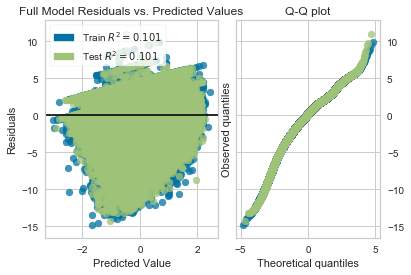

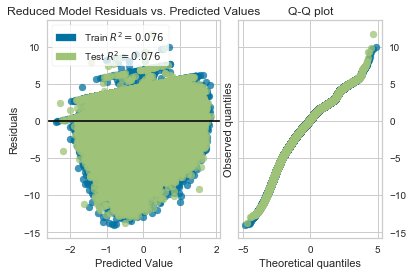

In [9]:
#visualize full model predicted residuals
model = LinearRegression()
visualizer = ResidualsPlot(model, hist=False, qqplot=True, title='Full Model Residuals vs. Predicted Values')
visualizer.fit(x_train_full, np.log(y_train_full))
visualizer.score(x_test_full, np.log(y_test_full))
visualizer.show()

#visualize reduced model predicted residuals
model = LinearRegression()
visualizer = ResidualsPlot(model, hist=False, qqplot=True, title='Reduced Model Residuals vs. Predicted Values')
visualizer.fit(x_train, np.log(y_train))
visualizer.score(x_test, np.log(y_test))
visualizer.show()